In [1]:
from __future__ import print_function, division
import mdtraj as md
from mdtraj.utils import ensure_type
from mdtraj.geometry import compute_distances, compute_angles
from mdtraj.geometry import _geometry
import os
import sys
import numpy as np
import scipy 
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
import itertools 
import pickle
import pandas as pd
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import pyblock
from mdtraj.geometry import _geometry
from mdtraj.utils import ensure_type
from mdtraj.geometry import compute_distances, compute_angles
from scipy.stats import pearsonr

from deeptime.clustering import KMeans
from deeptime.data import double_well_2d
from deeptime.markov import TransitionCountEstimator
from deeptime.markov.msm import BayesianMSM
from deeptime.plots import plot_implied_timescales
from deeptime.util.validation import implied_timescales 
from deeptime.plots.chapman_kolmogorov import plot_ck_test
import pyemma.coordinates
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pyinform

import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import deeptime
from deeptime.decomposition import TICA
import pyemma
from deeptime.clustering import KMeans

In [2]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 3.0

In [3]:
def fes2d(x,y,ax = None, xlabel = None,ylabel = None, cmap= 'jet',
           cbar = True, bins=250, weights=None, vmin=None,vmax=None,
           scatterx = None, scattery = None):
        z,x,y = np.histogram2d(x,y,bins=bins,weights=weights)
        extent = (x.min(), x.max(), y.min(), y.max())
        arr = np.ma.masked_array(z,z==0)
        F=-np.log(arr)
        F+=-F.min()
        if ax is None:
            fig,ax=plt.subplots(1,1,sharex=True,sharey=True)
        if not ((scatterx is None) or (scattery is None)):
            ax.scatter(scatterx, scattery, c='grey', s=60, edgecolors='black', alpha=0.5)
        a=ax.contourf(F.T,300,cmap=cmap,extent=extent,zorder=-1, vmin=vmin, vmax=vmax)
        ax.set_xlabel(xlabel,fontsize=25)
        ax.set_ylabel(ylabel,fontsize=25)
        ax.tick_params(axis="x",labelsize=20)
        ax.tick_params(axis="y",labelsize=20)
        ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))*1.0)
        if cbar:
            cb = plt.colorbar(a,ax=ax,fraction=0.046, pad=0.04,format="%.2f", )
            cb.set_label("Free Energy / (kT)",size=25,labelpad = 20)
            cb.ax.tick_params(labelsize = 20)
        return a
    
def plot_mat_error(mat,x,title,unit,
                   textsize,textcolor,cmap,ticklabs):
        """mat = square matrix
        unit = string specifying the units"""
        #fig,ax = plt.subplots(1,figsize=(20,20))
        s =ax[x].imshow(mat, cmap=cmap)
        for i in range(len(mat)):
            for j in range(len(mat)):
                c = mat[j, i]
                #e = emat[j,i]
                ax[x].text(i, j,f"{np.round(c,3)}",
                        va='center', ha='center', color = textcolor,size=textsize,weight="bold")
        ax[x].set_yticks(list(range(len(mat))), ticklabs,size=20)
        ax[x].set_xticks(list(range(len(mat))), ticklabs,size=20)
        #ax[x].set_ylabel(r"$State_{i}$", size=25)
        #ax[x].set_xlabel(r"$State_{j}$", size=25)
        #cb = plt.colorbar(s,ax=ax,label=cbarlabel,fraction=0.046,pad=0.04)
        #cb.set_label(cbarlabel, size=40)
        #cb.ax.tick_params(labelsize=30)
        ax[x].set_title(title, size = 25)
        #plt.show()
        return s
    
    
#customize pyemma source code
from pyemma.util.statistics import confidence_interval as _conf
from pyemma.util.types import is_iterable_of_int as _is_iterable_of_int, is_int as _is_int
import numpy as _np
__author__ = 'noe'


def plot_implied_timescales(ITS, ax=None, outfile=None, show_mle=True, show_mean=True,
                            xlog=False, ylog=True, confidence=0.95, refs=None, nits=-1,
                            process=None, units='steps', dt=1., **kwargs):
    r"""Implied timescale plot
    Parameters
    ----------
    ITS : implied timescales object.
        Object whose data will be plotted. Should be of type :class:`ImpliedTimescales <pyemma.msm.ImpliedTimescales>`
        or a 3-tuple with: 1d array of lagtimes, (lagtimes, processes) array of timescales,
        optionally (lagtimes, processes, samples) array of timescales of samples.
    ax : matplotlib Axes object, optional, default = None
        the axes to plot to. When set to None the default Axes object will be used.
    outfile : str, optional, default = None
        output file to write the figure to. When not given, the plot will be displayed
    show_mean : bool, default = True
        Line for mean value will be shown, if available
    show_mle : bool, default = True
        Line for maximum likelihood estimate will be shown
    xlog : bool, optional, default = False
        Iff true, the x-Axis is logarithmized
    ylog : bool, optional, default = True
        Iff true, the y-Axis is logarithmized
    confidence : float, optional, default = 0.95
        The confidence interval for plotting error bars (if available)
    refs : ndarray((m), dtype=float), optional, default = None
        Reference (exact solution or other reference) timescales if known. The number of timescales must match those
        in the ITS object
    nits: integer, default = -1
        Number of implied timescales to be shown. The default behaviour (-1) is to show all timescales available.
        :py:obj:`nits` != -1 and :py:obj:`process` != None are mutually exclusive
    process : iterable of integers, default is None
        list or ndarray((m), dtype=int) containing a list of the processes to be shown. The default behaviour is
        to show all timescales available.
        :py:obj:`process` != None and :py:obj:`nits` != -1 are mutually exclusive
    units: str or list (len=2) of strings, optional, default = 'steps'
        Affects the labeling of the axes. Used with :py:obj:`dt`, allows for changing the physical units of the axes.
        Accepts simple LaTeX math strings, eg. '$\mu$s'
        If this parameter is a list, it will be assumed that units[0] is for the x-axis and units[1] for the y-axis.
    dt: float or list(len=2) of floats, optional, default = 1.0
        Physical time between frames, expressed the units given in :py:obj:`units`. E.g, if you know that each
        frame corresponds to .010 ns, you can use the combination of parameters :py:obj:`dt` =0.01,
        :py:obj:`units` ='ns' to display the implied timescales in ns (instead of frames)
        If this parameter is a list, it will be assumed that dt[0] is for the x-axis and dt[1] for the y-axis.
    **kwargs: Will be passed to pyplot.plot when plotting the MLE datapoints (not the bootstrapped means).
            See the doc of pyplot for more options. Most useful lineproperties like `marker='o'` and/or :markersize=5
    Returns
    -------
    ax : Axes object containing the plot
    """
    if isinstance(ITS, tuple):
        assert len(ITS) in (2, 3)
        lags = _np.asarray(ITS[0])
        timescales = _np.asarray(ITS[1])
        timescales_samples = _np.asarray(ITS[2]) if len(ITS) == 3 and ITS[2] is not None else None
        n_timescales = timescales.shape[1]
        samples_available = timescales_samples is not None
    else:
        lags = ITS.lagtimes
        n_timescales = ITS.number_of_timescales
        timescales = ITS.get_timescales()
        samples_available = ITS.samples_available
        timescales_samples = ITS.timescales_samples
        if timescales_samples is not None:
            timescales_samples = timescales_samples.transpose(1, 2, 0)
    import matplotlib.pyplot as _plt
    # check input
    if ax is None:
        ax = _plt.gca(figsize= (10,6))
    colors = clist ######ADDED#####
    xmax = _np.max(lags)
    srt = _np.argsort(lags)
    # Check the processes to be shown
    if process is not None:
        if nits != -1:
            raise TypeError(
                'optional arguments nits and process are mutually exclusive:', nits, process)
        if not _is_iterable_of_int(process):
            raise ValueError('process has to be an iterable of integers')
        if _np.max(process)+1 > n_timescales:
            raise ValueError(
                'requested process %u, whereas ITS only contains %u timescales' % (
                    _np.max(process), n_timescales))
        # Now that it's for sure that nits==-1,
        # process is iter_of_ints, and the requested processes exist in its object:
        its_idx = process
    else:
        if not _is_int(nits):
            raise TypeError('nits is not an integer, ',nits)
        if nits == -1:
            nits = n_timescales
        its_idx = _np.arange(n_timescales)[:nits]
    # Check units and dt for user error.
    if isinstance(units, list) and len(units) != 2:
        raise TypeError("If units is a list, len(units) has to be = 2")
    if isinstance(dt, list) and len(dt) != 2:
        raise TypeError("If dt is a list, len(dt) has to be = 2")
    # Create list of units and dts for different axis
    if isinstance(units, str):
        units = [units] * 2
    if isinstance(dt, (float, int)):
        dt = [dt] * 2
    for i in its_idx:
        # plot estimate
        if show_mle:
            ax.plot(
                lags[srt] * dt[0], timescales[..., i][srt] * dt[1],
                color=colors[i % len(colors)], **kwargs)
        # sample available?
        if samples_available:
            # plot sample mean
            process_samples = timescales_samples[:, i, :].T
            if show_mean:
                sample_mean = _np.mean(process_samples, axis=0)
                ax.plot(
                    lags[srt] * dt[0], sample_mean[srt] * dt[1], marker='o',
                    color=colors[i % len(colors)], linestyle='dashed')
            lconf, rconf = _conf(process_samples, conf=confidence)
            ax.fill_between(
                lags[srt] * dt[0], lconf[srt] * dt[1], rconf[srt] * dt[1],
                alpha=0.2, color=colors[i % len(colors)])
        # reference available?
        if refs is not None:
            tref = refs[i] * dt[1]
            ax.plot([0, min(tref, xmax) * dt[0]], [tref, tref], color='black', linewidth=1)
    # cutoff
    ax.plot(lags[srt] * dt[0], lags[srt] * dt[1], linewidth=2, color='black')
    ax.set_xlim([1.0 * dt[0], xmax * dt[0]])
    ax.fill_between(
        lags[srt] * dt[0], ax.get_ylim()[0]*_np.ones(len(lags))*dt[1], lags[srt] * dt[1],
        alpha=0.2, color='grey')
    # formatting
    ax.set_xlabel('lag time / %s' % units[0])
    ax.set_ylabel('timescale / %s' % units[1])
    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')
    # show or save
    if outfile is not None:
        _plt.savefig(outfile)
    return ax

In [4]:
combined_inter_lig_47 = np.load("/data/asn/tica/lig_47/combined/combined_dist_matrix.npy")
dmat_lig_47 = np.load("/data/asn/tica/lig_47/dist/distance_matrix_full_LIG.npy")
proj_combined_lig_47 = np.load('/data/asn/tica/lig_47/combined/proj_combined_pcca_lig_47.npy')
dtraj_lig_47 = np.load('/data/asn/tica/lig_47/combined/dtraj_pcca_lig_47.npy' )
macro_dtraj_lig_47 = np.load("/data/asn/tica/lig_47/combined/lig47_pcca_macro_dtraj_4clusters.npy")

In [5]:
combined_inter_fasudil = np.load("/data/asn/tica/fasudil/combined/combined_dist_matrix.npy")
dmat_fasudil = np.load("/data/asn/tica/fasudil/dist/distance_matrix_fulL_FAS.npy")
proj_combined_fasudil = np.load('/data/asn/tica/fasudil/combined/proj_combined_pcca_fasudil.npy')
dtraj_fasudil = np.load('/data/asn/tica/fasudil/combined/dtraj_pcca_fasudil.npy' )
macro_dtraj_fasudil = np.load("/data/asn/tica/fasudil/combined/fas_pcca_macro_dtraj_4clusters.npy")


In [24]:
counts_lig_47 = deeptime.markov.TransitionCountEstimator(lagtime=100, count_mode="effective").fit(dtraj_lig_47).fetch_model()
mm_lig_47 = deeptime.markov.msm.BayesianMSM().fit(counts_lig_47).fetch_model()

counts_fasudil = deeptime.markov.TransitionCountEstimator(lagtime=100, count_mode="effective").fit(dtraj_fasudil).fetch_model()
mm_fasudil = deeptime.markov.msm.BayesianMSM().fit(counts_fasudil).fetch_model()

tmat_lig_47 = mm_lig_47.gather_stats(quantity = "transition_matrix").mean
tmat_fasudil = mm_fasudil.gather_stats(quantity = "transition_matrix").mean

states = 4
pcca_lig_47 = mm_lig_47.samples[0].pcca(states)
pcca_fasudil = mm_fasudil.samples[0].pcca(states)

pcca_tmat_lig_47 = pcca_lig_47.coarse_grained_transition_matrix
pcca_tmat_fasudil = pcca_fasudil.coarse_grained_transition_matrix

In [70]:
frames_cl_lig_47 = []
for i in range(4):
    frames = np.where(macro_dtraj_lig_47==i)[0]
    frames_cl_lig_47.append(frames)
        
frames_cl_fasudil = []
for i in range(4):
    frames = np.where(macro_dtraj_fasudil==i)[0]
    frames_cl_fasudil.append(frames)

In [7]:
#make tick labels
ticklabs = "1,2,3,4".split(",")
#make custom set of colors for each state
nstates = dtraj_lig_47.max()+1
color_list = plt.cm.viridis
cs = [color_list(i) for i in range(color_list.N)]
cmap = colors.ListedColormap(cs)
boundaries = np.arange(nstates+1).tolist()
clist = [cs[int(i)] for i in np.linspace(10,len(cs)-20,nstates)]
clist = clist[::-1]

/tmp/ipykernel_1361/2449190618.py:7: RuntimeWarning: divide by zero encountered in log
  F=-np.log(arr)


Text(0.5, -0.04, 'tiC1')

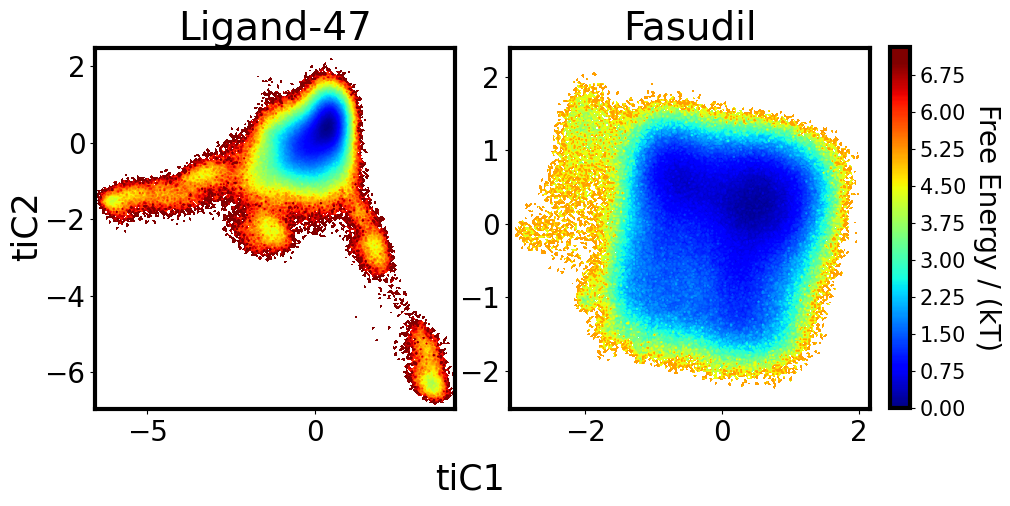

In [21]:
fig,ax = plt.subplots(1,2, sharex=False, sharey=False, figsize=(10, 5))

xlabel = 'tiC1'
ylabel = 'tiC2'
a = fes2d(proj_combined_lig_47[:,0], proj_combined_lig_47[:,1], ax[0], cbar = False, vmin=0.00,vmax=7.0) 
fes2d(proj_combined_fasudil[:,0], proj_combined_fasudil[:,1], ax[1], cbar = False, vmin=0.00,vmax=7.0) 
cbar_ax = fig.add_axes([.92, 0.1354, 0.02, 0.723])#[left, bottom, width, height]
cbar = fig.colorbar(a, cax = cbar_ax)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Free Energy / (kT)', labelpad=25, fontsize=20, rotation= 270)
ax[0].set_title('Ligand-47', size = 28)
ax[1].set_title('Fasudil', size = 28)
plt.subplots_adjust(wspace=0.15)
fig.supylabel(ylabel,x = .04,fontsize = 25)
fig.supxlabel(xlabel,y = -0.04,fontsize = 25)


Text(0.5, -0.01, '$State_{j}$')

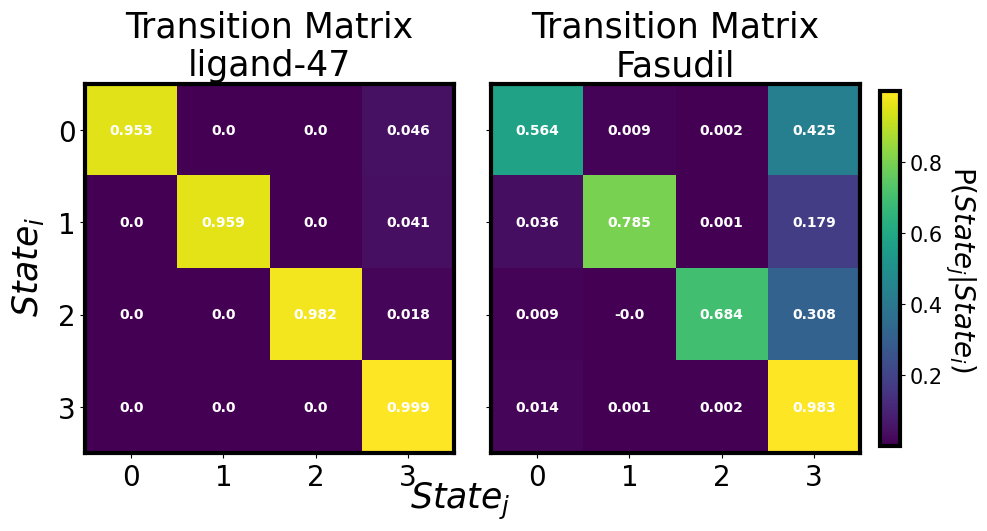

In [33]:
#transition matrix errors
xlabel = r"$State_{j}$"
ylabel = r"$State_{i}$"

fig,ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10, 5))


a = plot_mat_error(pcca_tmat_lig_47,0,"Transition Matrix\nligand-47","%",10,"white","viridis",np.arange(4))

plot_mat_error(pcca_tmat_fasudil,1,"Transition Matrix\nFasudil","%",10,"white","viridis",np.arange(4))

cbar_ax = fig.add_axes([.92, 0.14, 0.02, 0.71])#[left, bottom, width, height]
cbar = fig.colorbar(a, cax = cbar_ax)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r"P($State_{j}$|$State_{i}$)", labelpad=25, fontsize=20, rotation= 270)
plt.subplots_adjust(wspace=0.1)
fig.supylabel(ylabel,x = 0.05,fontsize = 25)
fig.supxlabel(xlabel,y = -0.01,fontsize = 25)

Text(0.5, -0.01, 'States')

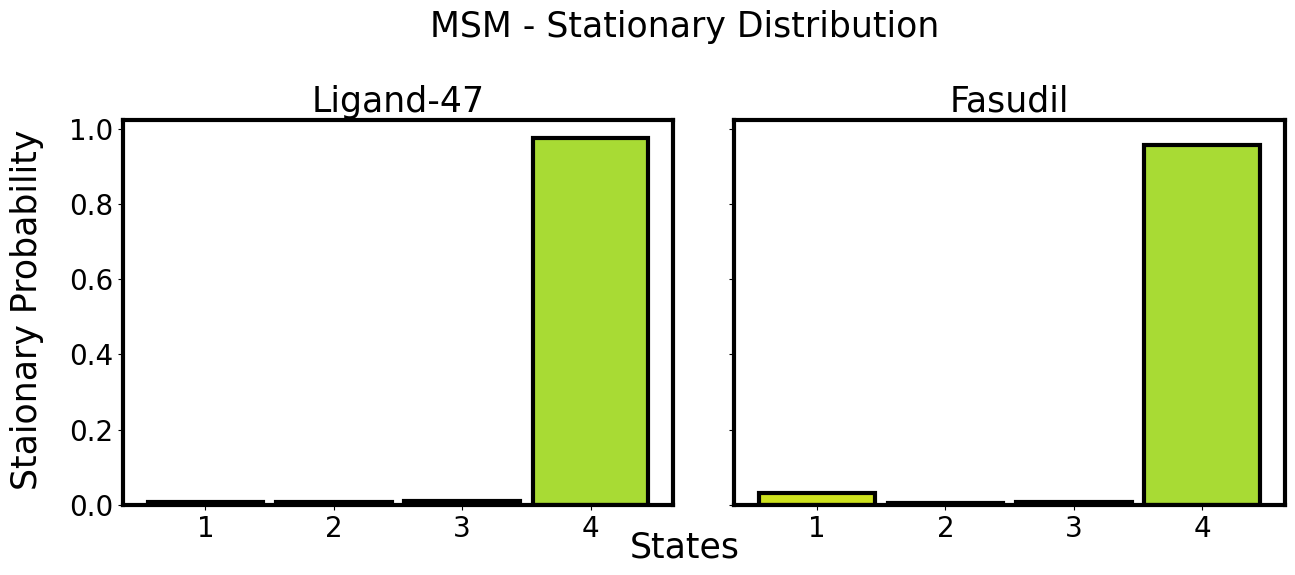

In [62]:
fig,ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(15, 5))

xlabel = "States"
ylabel = 'Staionary Probability'

#plt.figure(figsize = (10,6))
ax[0].bar(np.arange(states), pcca_lig_47.coarse_grained_stationary_probability,
        ecolor="grey",color=clist,capsize=10,width=.9,linewidth=3, edgecolor = "black",
        align="center",error_kw=dict(capthick=3,lw=3))

ax[1].bar(np.arange(states), pcca_fasudil.coarse_grained_stationary_probability,
        ecolor="grey",color=clist,capsize=10,width=.9,linewidth=3, edgecolor = "black",
        align="center",error_kw=dict(capthick=3,lw=3))

plt.xticks(np.arange(states), ticklabs)
#plt.xlabel("State", size=30)
#plt.ylabel("Staionary Probability", size=30)
ax[0].set_title("Ligand-47",size=25)
ax[1].set_title("Fasudil",size=25)
ax[0].tick_params(axis='both', labelsize=20)
ax[1].tick_params(axis='both', labelsize=20)
#plt.yticks(size = 30)
#plt.xlim(.5,states)
plt.subplots_adjust(wspace=0.11)
fig.suptitle("MSM - Stationary Distribution",y = 1.1,size=25)
fig.supylabel(ylabel,x = 0.05,fontsize = 25)
fig.supxlabel(xlabel,y = -0.01,fontsize = 25)

In [57]:
its_lig_47 = pyemma.msm.its(macro_dtraj_lig_47,np.arange(1,500,5), nits=nstates-1, errors="bayes", nsamples = 100, n_jobs=1)  

estimating BayesianMSM:   0%|                           | 0/100 [00:00<?, ?it/s]

Exception ignored in: <built-in method acquire of _thread.lock object at 0x7f747694a840>
Traceback (most recent call last):
  File "/home/apara/miniconda3/envs/pyemma/lib/python3.10/multiprocessing/popen_fork.py", line 66, in _launch
    self.pid = os.fork()
KeyboardInterrupt: 


21-09-23 14:08:06 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[398] WARNING  Changed user setting nits to the number of available timescales nits=3


In [54]:
its_fasudil = pyemma.msm.its(macro_dtraj_fasudil,np.arange(1,500,5), nits=nstates-1, errors="bayes", nsamples = 100,n_jobs=1)

estimating BayesianMSM:   0%|                           | 0/100 [00:00<?, ?it/s]

21-09-23 13:49:56 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[292] WARNING  Changed user setting nits to the number of available timescales nits=3


Text(0.5, 1.03, 'MSM - Implied Timescales')

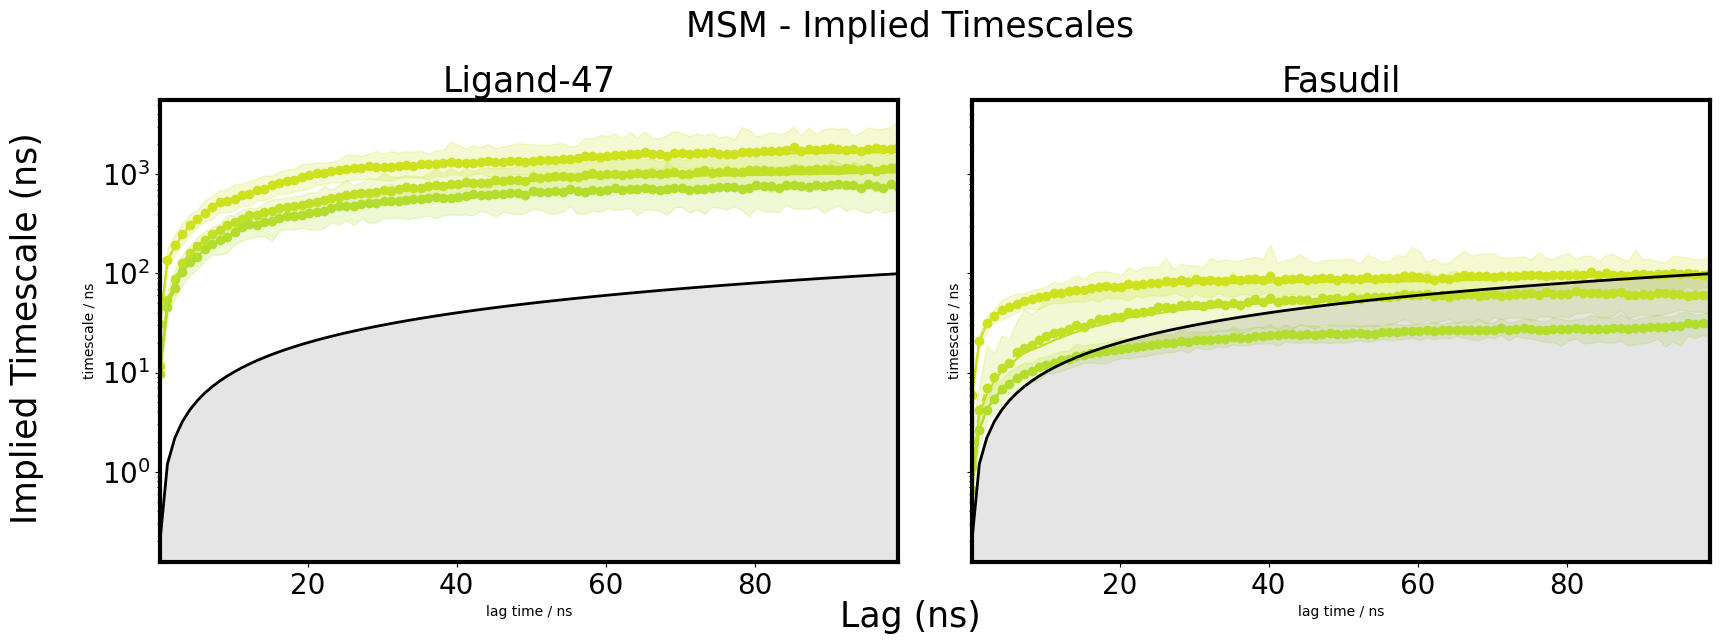

In [68]:
xlabel = "Lag (ns)"
ylabel = 'Implied Timescale (ns)'


fig,ax = plt.subplots(1,2, sharex=True, sharey=True,figsize=(20,6))
plot_implied_timescales(its_lig_47,units="ns", dt=.2,ax=ax[0])
plot_implied_timescales(its_fasudil,units="ns", dt=.2,ax=ax[1])
ax[0].set_title("Ligand-47",size=25)
ax[1].set_title("Fasudil",size=25)
ax[0].tick_params(axis='both', labelsize=20)
ax[1].tick_params(axis='both', labelsize=20)

plt.subplots_adjust(wspace=0.1)
fig.supylabel(ylabel,x = 0.05,fontsize = 25)
fig.supxlabel(xlabel,y = -0.01,fontsize = 25)
fig.suptitle("MSM - Implied Timescales",y = 1.03,size=25)
#ax.set_xlabel("Lag (ns)",size=30)
#ax.set_ylabel("Implied Timescale (ns)",size=30)
#ax.set_title("MSM - Implied Timescales",size=25)
#ax.tick_params("both", labelsize=25)

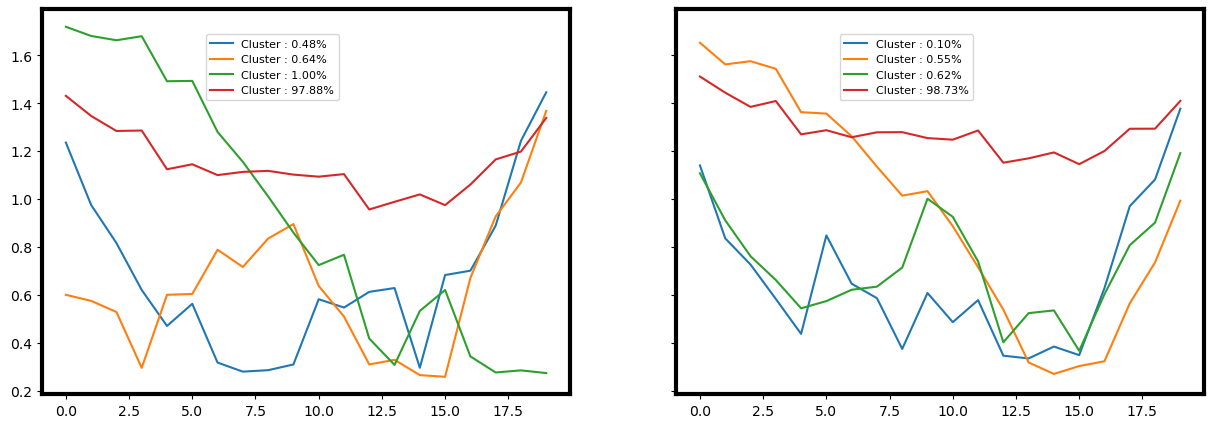

In [71]:
#xlabel = 'PC1'
ylabel = 'Number of Frames'

fig,ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(15, 5))


for i in frames_cl_lig_47:
    ax[0].plot(dmat_lig_47[i].mean(0), label = f"Cluster : {100*len(i)/len(dmat_lig_47):.2f}%")
    ax[0].legend(ncol = 1, prop={'size': 8}, bbox_to_anchor=(0.3, 0.75, 0., 0.))
    #plt.yticks(fontsize = 14)
    #plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'), rotation=90, fontsize = 14)
    #plt.xlabel('Residue', fontsize = 20)
    #plt.ylabel('Average Distance\nfor Each Cluster', fontsize = 20)

for i in frames_cl_fasudil:
    ax[1].plot(dmat_fasudil[i].mean(0), label = f"Cluster : {100*len(i)/len(dmat_fasudil):.2f}%")
    ax[1].legend(ncol = 1, prop={'size': 8}, bbox_to_anchor=(0.3, 0.75, 0., 0.))
    #plt.yticks(fontsize = 14)
    #plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'), rotation=90, fontsize = 14)
    #plt.xlabel('Residue', fontsize = 20)
    #plt.ylabel('Average Distance\nfor Each Cluster', fontsize = 20)

In [10]:
residues = 21
residue_offset = 121
residue_number = range(0, residues)
residue_number_offset = range(residue_offset, residue_offset+residues)

Text(1618.4027777777778, 0.5, 'Contact Probability')

<Figure size 640x480 with 0 Axes>

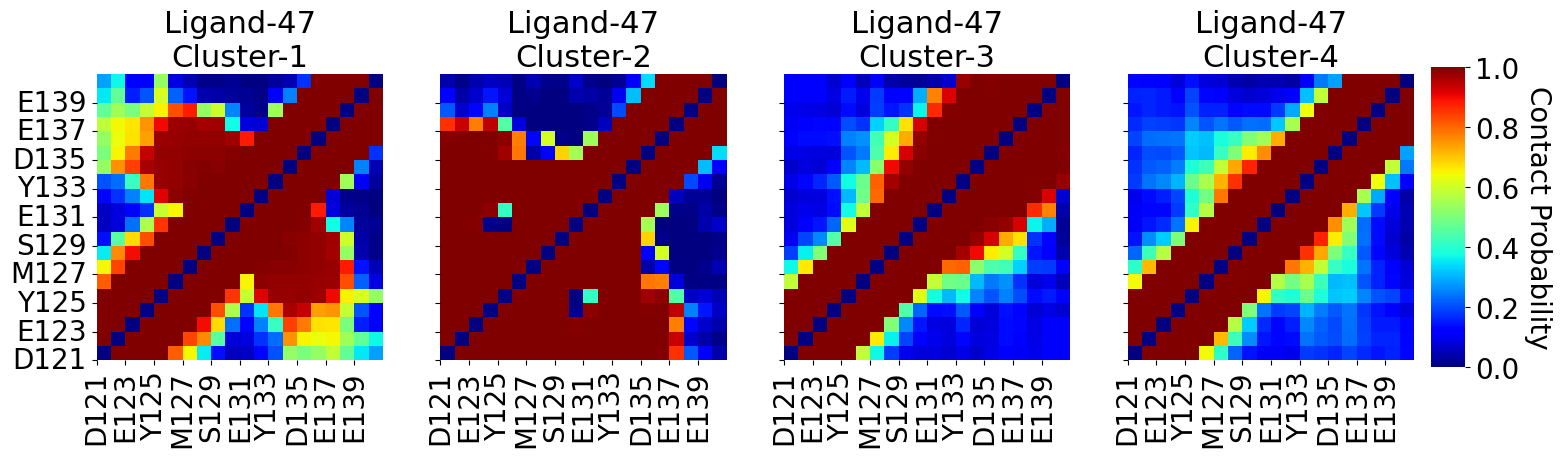

In [6]:
C = np.load("pep_contact_pcca_lig.npy")
res_ = ('D121','E123','Y125','M127','S129','E131','Y133','D135','E137','E139')
#title = 'Mutual Information \n Charge-contacts - Intermolecular-distances'
#xlabel = 'Intermolecular-distances'
#ylabel = 'Charge-contacts'
plt.subplots_adjust(wspace=0.01, hspace=1)
ncol = 4
nrow = 1
fig, ax = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(17, 4))
cbar_ax = fig.add_axes([.91, .12, .02, .75])
for i in range(4):
    #contact_map = np.loadtxt(f"./Analysis/contact_map.{i}.dat")
    contact_map = C[i]
    p = np.unravel_index(i,(5))
    cb = i==1
    plot = sns.heatmap(contact_map, ax=ax[p], vmin = 0, vmax= 1, cmap = "jet",  cbar=cb, cbar_ax=cbar_ax)
                  #xticklabels = res, yticklabels = charge_res)
    #cbar = ax.collections[0].colorbar
    #cbar.set_label(label = "MI",size = 15)
    #cbar.ax.tick_params(labelsize=15)
    ax[p].invert_yaxis()
    ax[p].tick_params(axis = 'x', rotation = 90)
    ax[p].set_title('Ligand-47\nCluster-'+str(i+1),size=22)
    ax[p].set_aspect('equal', 'box')
    ax[p].set_xticks(range(0, 20,2), res_, rotation=90, size=20)
    ax[p].set_yticks(range(0, 20,2), res_, rotation=0, size=20)
    #ax[p].set_xlabel(xlabel, size = 15)
    #ax[p].set_ylabel(ylabel, size = 15)
cbar_ax.tick_params(labelsize=20)
cbar_ax.set_ylabel('Contact Probability', rotation=270, fontsize = 20, labelpad=24)
#plt.savefig('Lig47_pep_contact.png', bbox_inches="tight")

Text(1618.4027777777778, 0.5, 'Contact Probability')

<Figure size 640x480 with 0 Axes>

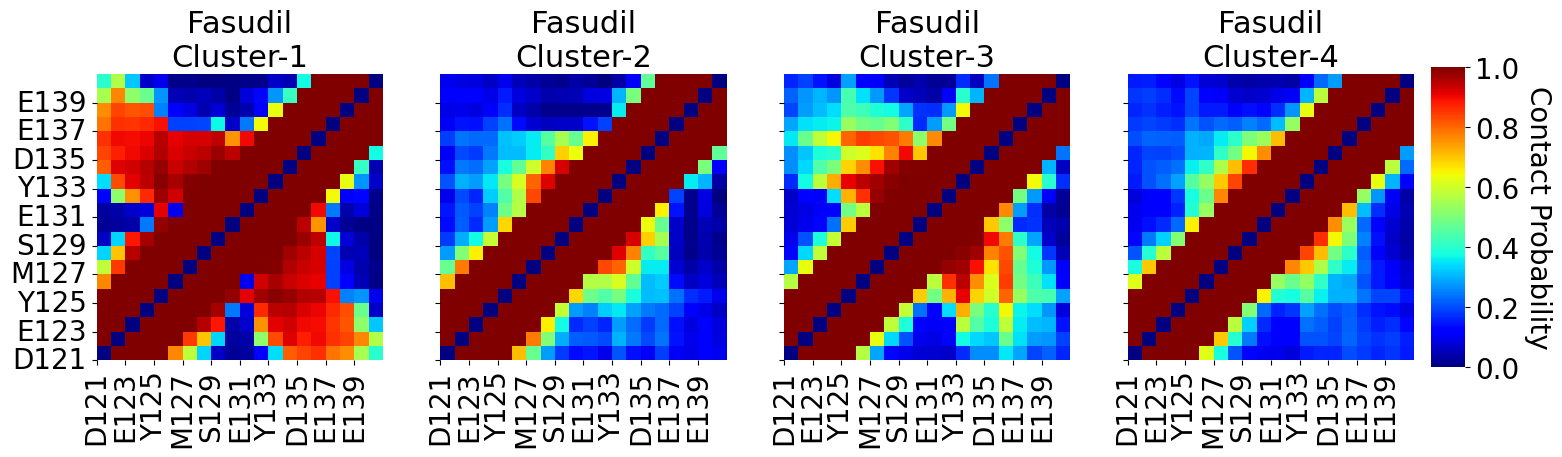

In [4]:
C = np.load("/data/asn/tica/fasudil/combined/pep_contact_pcca_fas.npy")
res_ = ('D121','E123','Y125','M127','S129','E131','Y133','D135','E137','E139')
#title = 'Mutual Information \n Charge-contacts - Intermolecular-distances'
#xlabel = 'Intermolecular-distances'
#ylabel = 'Charge-contacts'
plt.subplots_adjust(wspace=0.01, hspace=1)
ncol = 4
nrow = 1
fig, ax = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(17, 4))
cbar_ax = fig.add_axes([.91, .12, .02, .75])
for i in range(4):
    #contact_map = np.loadtxt(f"./Analysis/contact_map.{i}.dat")
    contact_map = C[i]
    p = np.unravel_index(i,(5))
    cb = i==1
    plot = sns.heatmap(contact_map, ax=ax[p], vmin = 0, vmax= 1, cmap = "jet",  cbar=cb, cbar_ax=cbar_ax)
                  #xticklabels = res, yticklabels = charge_res)
    #cbar = ax.collections[0].colorbar
    #cbar.set_label(label = "MI",size = 15)
    #cbar.ax.tick_params(labelsize=15)
    ax[p].invert_yaxis()
    ax[p].tick_params(axis = 'x', rotation = 90)
    ax[p].set_title('Fasudil\nCluster-'+str(i+1),size=22)
    ax[p].set_aspect('equal', 'box')
    ax[p].set_xticks(range(0, 20,2), res_, rotation=90, size=20)
    ax[p].set_yticks(range(0, 20,2), res_, rotation=0, size=20)
    #ax[p].set_xlabel(xlabel, size = 15)
    #ax[p].set_ylabel(ylabel, size = 15)
cbar_ax.tick_params(labelsize=20)
cbar_ax.set_ylabel('Contact Probability', rotation=270, fontsize = 20, labelpad=24)
#plt.savefig('fas_pep_contact.png', bbox_inches="tight")

Text(1618.4027777777778, 0.5, 'Contact Probability')

<Figure size 640x480 with 0 Axes>

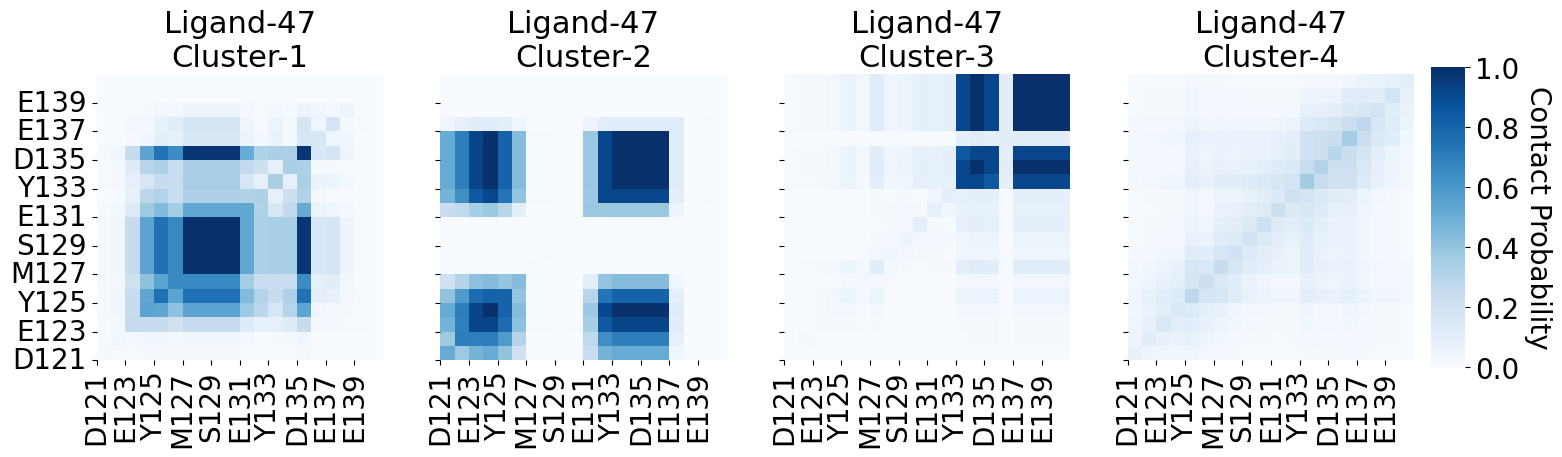

In [5]:
C_ = np.load("dual_contact_pcca_lig.npy")
res_ = ('D121','E123','Y125','M127','S129','E131','Y133','D135','E137','E139')
#title = 'Mutual Information \n Charge-contacts - Intermolecular-distances'
#xlabel = 'Intermolecular-distances'
#ylabel = 'Charge-contacts'
plt.subplots_adjust(wspace=0.01, hspace=1)
ncol = 4
nrow = 1
fig, ax = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(17, 4))
cbar_ax = fig.add_axes([.91, .12, .02, .75])
for i in range(4):
    #contact_map = np.loadtxt(f"./Analysis/contact_map.{i}.dat")
    contact_map = C_[i]
    p = np.unravel_index(i,(5))
    cb = i==1
    plot = sns.heatmap(contact_map, ax=ax[p], vmin = 0, vmax= 1, cmap = "Blues",  cbar=cb, cbar_ax=cbar_ax)
                  #xticklabels = res, yticklabels = charge_res)
    #cbar = ax.collections[0].colorbar
    #cbar.set_label(label = "MI",size = 15)
    #cbar.ax.tick_params(labelsize=15)
    ax[p].invert_yaxis()
    ax[p].tick_params(axis = 'x', rotation = 90)
    ax[p].set_title('Ligand-47\nCluster-'+str(i+1),size=22)
    ax[p].set_aspect('equal', 'box')
    ax[p].set_xticks(range(0, 20,2), res_, rotation=90, size=20)
    ax[p].set_yticks(range(0, 20,2), res_, rotation=0, size=20)
    #ax[p].set_xlabel(xlabel, size = 15)
    #ax[p].set_ylabel(ylabel, size = 15)
cbar_ax.tick_params(labelsize=20)
cbar_ax.set_ylabel('Contact Probability', rotation=270, fontsize = 20, labelpad=24)
#plt.savefig('Lig47_dual_contact.png', bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

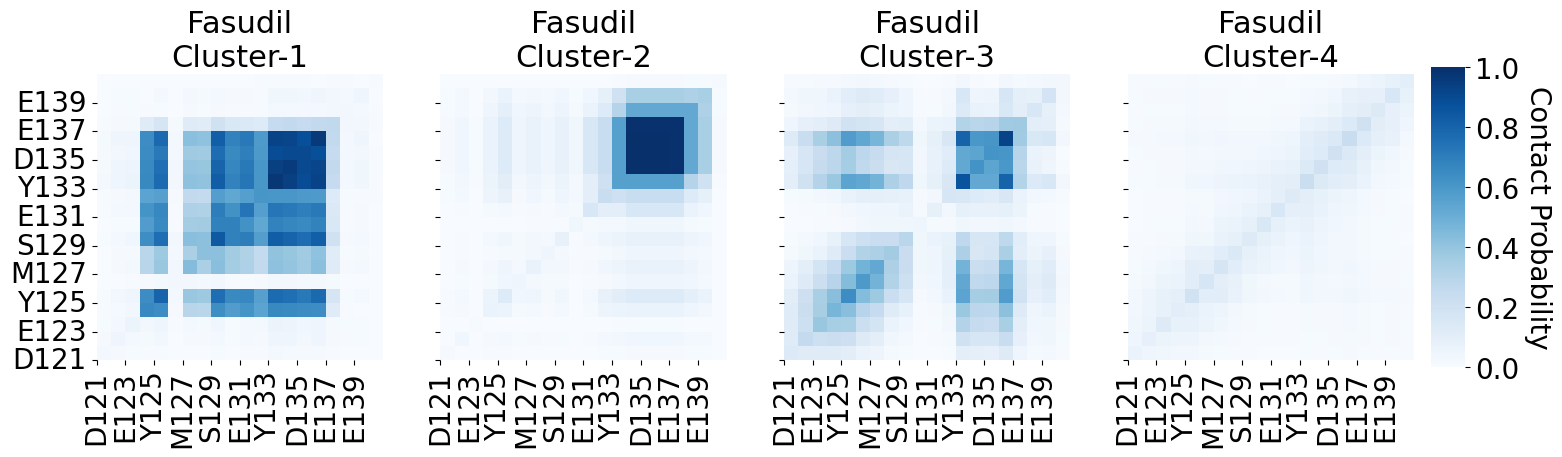

In [8]:
C_ = np.load("/data/asn/tica/fasudil/combined/dual_contact_pcca_fas.npy")
res_ = ('D121','E123','Y125','M127','S129','E131','Y133','D135','E137','E139')
#title = 'Mutual Information \n Charge-contacts - Intermolecular-distances'
#xlabel = 'Intermolecular-distances'
#ylabel = 'Charge-contacts'
plt.subplots_adjust(wspace=0.01, hspace=1)
ncol = 4
nrow = 1
fig, ax = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(17, 4))
cbar_ax = fig.add_axes([.91, .12, .02, .75])
for i in range(4):
    #contact_map = np.loadtxt(f"./Analysis/contact_map.{i}.dat")
    contact_map = C_[i]
    p = np.unravel_index(i,(5))
    cb = i==1
    plot = sns.heatmap(contact_map, ax=ax[p], vmin = 0, vmax= 1, cmap = "Blues",  cbar=cb, cbar_ax=cbar_ax)
                  #xticklabels = res, yticklabels = charge_res)
    #cbar = ax.collections[0].colorbar
    #cbar.set_label(label = "MI",size = 15)
    #cbar.ax.tick_params(labelsize=15)
    ax[p].invert_yaxis()
    ax[p].tick_params(axis = 'x', rotation = 90)
    ax[p].set_title('Fasudil\nCluster-'+str(i+1),size=22)
    ax[p].set_aspect('equal', 'box')
    ax[p].set_xticks(range(0, 20,2), res_, rotation=90, size=20)
    ax[p].set_yticks(range(0, 20,2), res_, rotation=0, size=20)
    #ax[p].set_xlabel(xlabel, size = 15)
    #ax[p].set_ylabel(ylabel, size = 15)
cbar_ax.tick_params(labelsize=20)
cbar_ax.set_ylabel('Contact Probability', rotation=270, fontsize = 20, labelpad=24)
plt.savefig('fas_dual_contact.png', bbox_inches="tight")

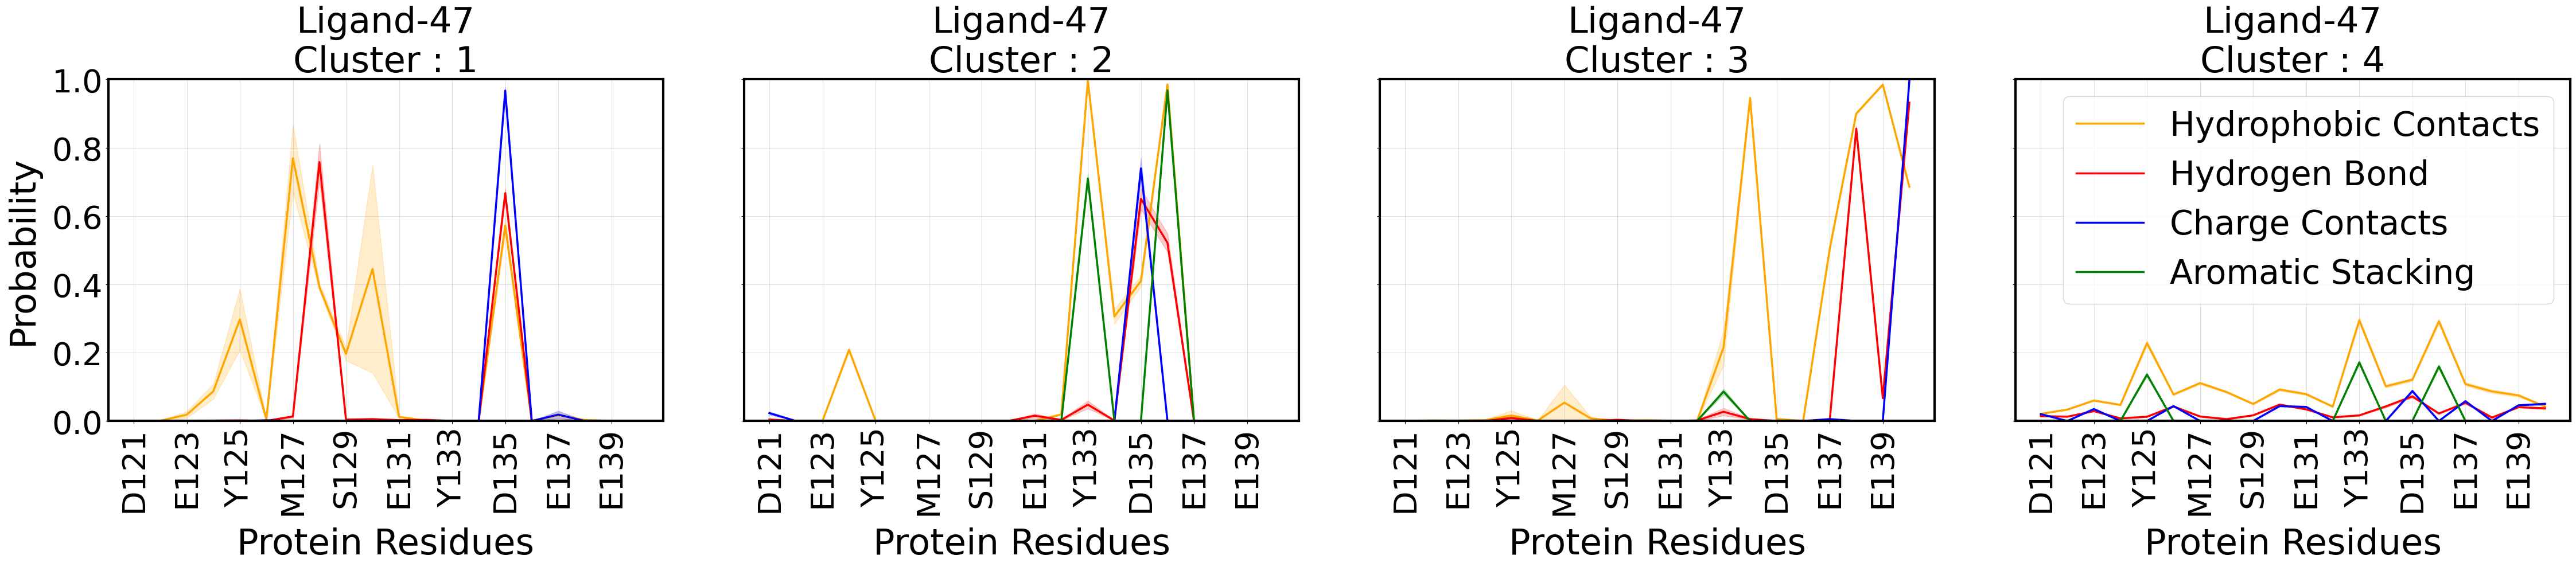

In [9]:
Hbond= np.load("intermol_Hbond_pcca_lig.npy" )
charge_= np.load("intermol_charge_pcca_lig.npy")
aro_ = np.load("intermol_aro_pcca_lig.npy")
hydro = np.load("intermol_hydro_pcca_lig.npy")

fig, ax = plt.subplots(1, 4, figsize=(45, 10), sharex=True, sharey=True)
#res = np.array([str(trj[0].topology.residue(i)) for i in range(20)])
res_ = ('D121','E123','Y125','M127','S129','E131','Y133','D135','E137','E139')

for i in range(4):
    p = np.unravel_index(i,(4))
    
    ax[p].plot(hydro[i].T[0], hydro[i].T[1], linewidth=2.5, label='Hydrophobic Contacts', color='orange')
    ax[p].fill_between(hydro[i].T[0], hydro[i].T[1]-hydro[i].T[2],
                          hydro[i].T[1]+hydro[i].T[2], alpha=0.2,color='orange')
    
    ax[p].plot(Hbond[i].T[0], Hbond[i].T[1], linewidth=2.5,label='Hydrogen Bond', color='red')
    ax[p].fill_between(Hbond[i].T[0], Hbond[i].T[1]-Hbond[i].T[2],
                          Hbond[i].T[1]+Hbond[i].T[2], alpha=0.2,color='r')
    
    ax[p].plot(charge_[i].T[0], charge_[i].T[1], linewidth=2.5,label='Charge Contacts',c='blue')
    ax[p].fill_between(charge_[i].T[0], charge_[i].T[1]-charge_[i].T[2],
                          charge_[i].T[1]+charge_[i].T[2], alpha=0.2,color='blue')
    
    ax[p].plot(aro_[i].T[0], aro_[i].T[1], linewidth=2.5, color='green', label='Aromatic Stacking')
    ax[p].fill_between(aro_[i].T[0], aro_[i].T[1]-aro_[i].T[2],
                         aro_[i].T[1]+aro_[i].T[2], alpha=0.2,color='green')
    
    ax[p].set_ylim(0,1.0)
    ax[p].set_xticks(range(int(min(Hbond[i][:,0])),int(max(Hbond[i][:,0])+1),2))
    ax[p].set_xticklabels(res_)
    ax[p].tick_params(labelsize=40)
    ax[p].grid(alpha=0.4)
    plt.setp(ax[p].get_xticklabels(), rotation=90)
    
    
    if i == 3:
        ax[p].legend(loc=1,prop={'size': 42})

    a='Ligand-47\nCluster : '+str(i+1)
    ax[p].set_title(a,size=45)
    
    #text_=r'$K_{D}$'+' : '+str(round(K[2][i],2))+r'$\pm$'+str(round(K[3][i],2))
    #ax[p].text(120.3, 0.63, text_, fontsize = 26)
    
    ax[0].set_ylabel("Probability", size=45, labelpad=15)
    ax[p].set_xlabel('Protein Residues', size=45, labelpad=15)
        
plt.tight_layout()

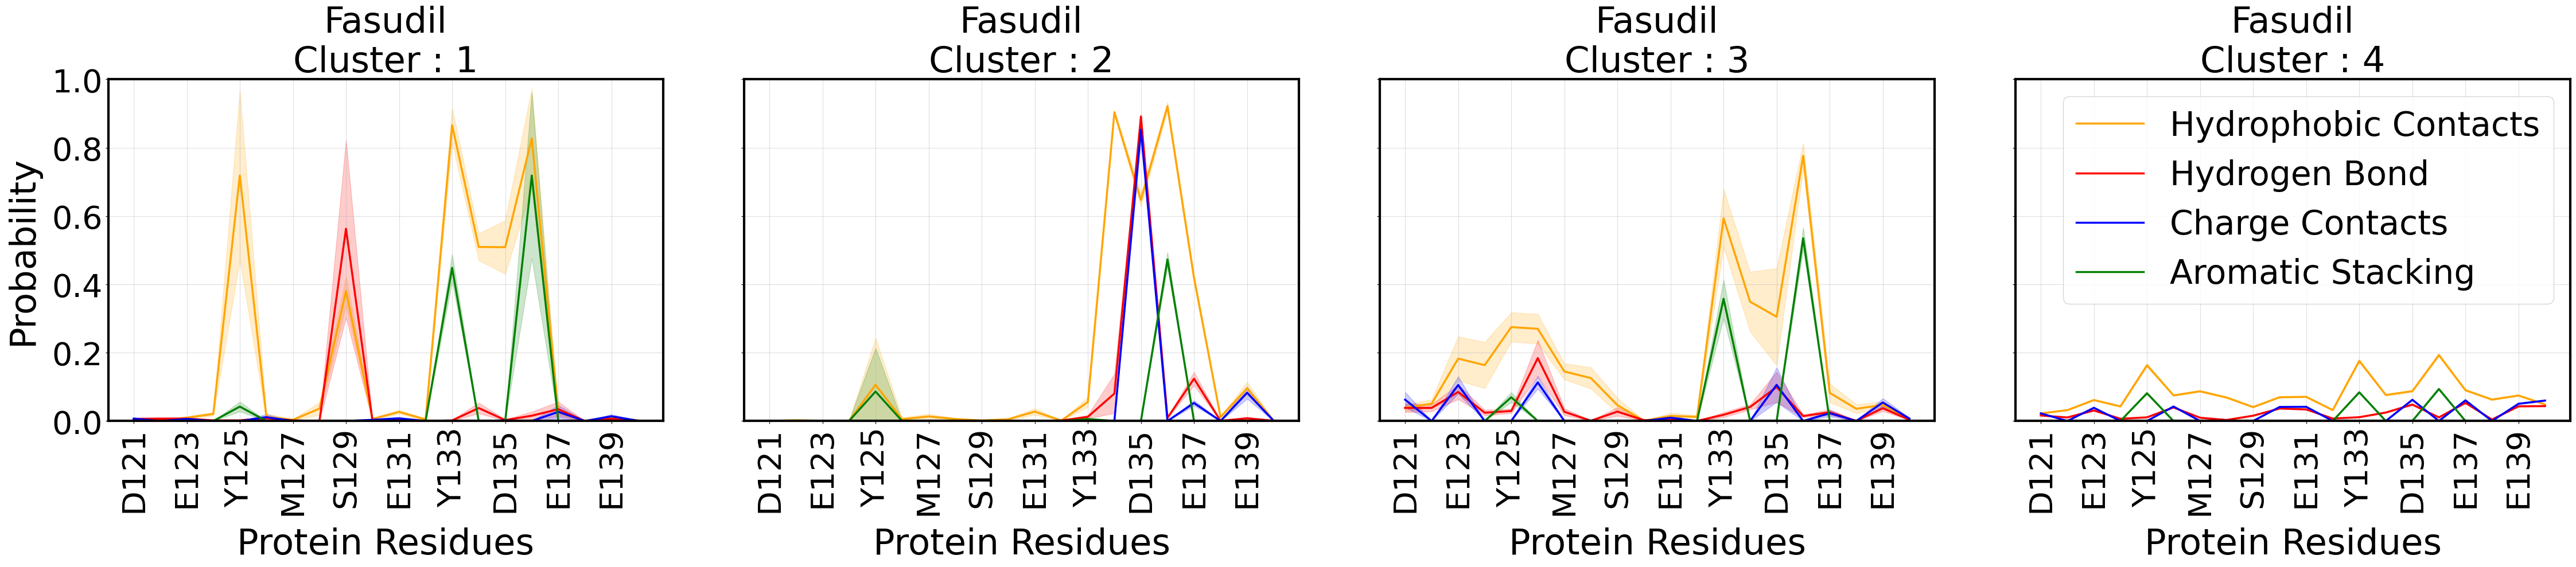

In [10]:
Hbond= np.load("/data/asn/tica/fasudil/combined/intermol_Hbond_pcca_fas.npy" )
charge_= np.load("/data/asn/tica/fasudil/combined/intermol_charge_pcca_fas.npy")
aro_ = np.load("/data/asn/tica/fasudil/combined/intermol_aro_pcca_fas.npy")
hydro = np.load("/data/asn/tica/fasudil/combined/intermol_hydro_pcca_fas.npy")

fig, ax = plt.subplots(1, 4, figsize=(45, 10), sharex=True, sharey=True)
#res = np.array([str(trj[0].topology.residue(i)) for i in range(20)])
res_ = ('D121','E123','Y125','M127','S129','E131','Y133','D135','E137','E139')

for i in range(4):
    p = np.unravel_index(i,(4))
    
    ax[p].plot(hydro[i].T[0], hydro[i].T[1], linewidth=2.5, label='Hydrophobic Contacts', color='orange')
    ax[p].fill_between(hydro[i].T[0], hydro[i].T[1]-hydro[i].T[2],
                          hydro[i].T[1]+hydro[i].T[2], alpha=0.2,color='orange')
    
    ax[p].plot(Hbond[i].T[0], Hbond[i].T[1], linewidth=2.5,label='Hydrogen Bond', color='red')
    ax[p].fill_between(Hbond[i].T[0], Hbond[i].T[1]-Hbond[i].T[2],
                          Hbond[i].T[1]+Hbond[i].T[2], alpha=0.2,color='r')
    
    ax[p].plot(charge_[i].T[0], charge_[i].T[1], linewidth=2.5,label='Charge Contacts',c='blue')
    ax[p].fill_between(charge_[i].T[0], charge_[i].T[1]-charge_[i].T[2],
                          charge_[i].T[1]+charge_[i].T[2], alpha=0.2,color='blue')
    
    ax[p].plot(aro_[i].T[0], aro_[i].T[1], linewidth=2.5, color='green', label='Aromatic Stacking')
    ax[p].fill_between(aro_[i].T[0], aro_[i].T[1]-aro_[i].T[2],
                         aro_[i].T[1]+aro_[i].T[2], alpha=0.2,color='green')
    
    ax[p].set_ylim(0,1.0)
    ax[p].set_xticks(range(int(min(Hbond[i][:,0])),int(max(Hbond[i][:,0])+1),2))
    ax[p].set_xticklabels(res_)
    ax[p].tick_params(labelsize=40)
    ax[p].grid(alpha=0.4)
    plt.setp(ax[p].get_xticklabels(), rotation=90)
    
    
    if i == 3:
        ax[p].legend(loc=1,prop={'size': 42})

    a='Fasudil\nCluster : '+str(i+1)
    ax[p].set_title(a,size=45)
    
    #text_=r'$K_{D}$'+' : '+str(round(K[2][i],2))+r'$\pm$'+str(round(K[3][i],2))
    #ax[p].text(120.3, 0.63, text_, fontsize = 26)
    
    ax[0].set_ylabel("Probability", size=45, labelpad=15)
    ax[p].set_xlabel('Protein Residues', size=45, labelpad=15)
        
plt.tight_layout()